In [0]:
# output and formatting
import pprint
from textwrap import wrap, indent
import matplotlib.pyplot as plt
import seaborn as sns

# to construct an example dataset
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import hashlib

import pandas as pd
import numpy as np

import requests                        # to run API calls
import srsly                           # to decode output
from more_itertools import chunked     # to batch data for API calls
import itertools

import os                              # to read the API key from a shell variable

# to compute metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score

# for type checking
from typing import Iterable, Dict
from requests.models import Response

[nltk_data] Downloading package reuters to /root/nltk_data...


In [0]:
NTRAIN     =  500  # number of documents to train on
NTEST      = 5000  # number of "test" documents to evaluate model metrics
INDEX_NAME = "NLTK-Reuters-Train-Demo"   # name for the index

API_KEY = os.environ['STURDY_STATS_API_KEY']

# Make a dataset

To get started, we'll look at the Reuters sample dataset from NLTK.
This is a subset of the "Reuters-21578 dataset;" while it's very outdated, and more than a little idiosyncratic, it is a well-known benchmark for text classification.
It provides a familiar starting point to get into the Sturdy Stats system.

The short articles in this dataset were collected from the Reuters financial newswire service in 1987, and are organized into about 90 categories.

In [0]:
# load the reuters data into a pandas DataFrame:
df = pd.DataFrame({'id': reuters.fileids()})

df['tags'] = df['id'].apply(lambda id: reuters.categories(id))
df['doc']  = df['id'].apply(lambda id: " ".join(reuters.words(id)))

# sort articles by the md5 hash for a consistent (and approximately random) ordering:
df['doc_id'] = df['doc'].apply(lambda id: hashlib.md5(id.encode('utf-8')).hexdigest())

df.sort_values(by='doc_id', inplace=True)
df.drop_duplicates(subset='doc_id', inplace=True)
df.reset_index(drop=True, inplace=True)

# split out into a test set, a train set, and a remainder
# - the remainder may be used for unsupervised language modeling in order to adapt
#   our AI model to this specific corpus.
df_train = df.iloc[:NTRAIN].copy()
df_test  = df.iloc[NTRAIN:NTRAIN+NTEST].copy()
df_extra = df.iloc[NTRAIN+NTEST:].copy()
del(df)

print(f"""Using {len(df_train):,.0f} documents for training and {len(df_test):,.0f} for testing""")
print(f"""{len(df_extra):,.0f} documents remain for unsupervised language modeling""")

df_train.head()

Using 500 documents for training and 5,000 for testing
5,152 documents remain for unsupervised language modeling


,id,tags,doc,doc_id
0,training/730,"[acq, earn]",ICI & lt ; ICI > SEEKS GAINS IN SPECIALTY BUSI...,00034506199dbca1d8ca109c5bbccac3
1,training/5796,[crude],STUDY PREDICTS U . S . DEPENDENCE ON FOREIGN O...,0004f3fc0420877a4e80066110a665a3
2,test/15901,[earn],JAMES RIVER CORP & lt ; JR > SETS REGULAR PAYO...,000c4dac701a1ec79b7e24d1c729b743
3,training/10340,"[gnp, money-fx]",ITALIAN 1987 GDP GROWTH FORECAST AT THREE PCT ...,000cbe04c45522c49fee80ffa5794613
4,test/19874,[acq],MCCHIP & lt ; MCS . TO > TO ACQUIRE RESERVE HO...,001463b41dd30e6311ed6dc1fdc84321


You can get a sense of the dataset by looking at a few examples.
Some of them are very terse, while others read like short articles.

In [0]:
def mywrap(text):
    lines = wrap(text, width=75)
    return indent('\n'.join(lines), prefix="    ")

for j in (200, 300, 400):
    row = df_train.iloc[j]
    print(row['id'], ','.join(row['tags']), sep=": ", end="\n\n")
    print(mywrap(row['doc']), end="\n\n")

test/20257: earn

    CONSTELLATION BANCORP & lt ; CSTL . O > 3RD QTR NET Shr 78 cts vs 61 cts
    Net 4 , 774 , 000 vs 3 , 683 , 000 Nine mths Shr 2 . 14 dlrs vs 1 . 77 dlrs
    Net 13 . 1 mln vs 10 . 7 mln

training/2440: earn

    HUMANA INC & lt ; HUM > REGULAR DIVIDEND Qtly div 19 cts vs 19 cts in prior
    qtr Payable May one Record April two

training/5057: trade

    TRADE BILL TO CHANGE AGRICULTURE TRADE LAWS The House Ways and Means
    Committee is moving toward passage of a trade bill that sponsors said was
    intended to help open foreign markets to U . S . agricultural goods and to
    modify some U . S . agricultural trade laws . The trade subcommittee voted
    to require President Reagan to take into account the potential harm to U .
    S . agricultural exports of any trade retaliation he might impose for
    foreign unfair trade practices against other domestic industries . The bill
    would allow U . S . agricultural producers to seek government monitoring of
    

# Python wrappers for API tasks

We'll go ahead and define some python functions for common tasks in machine learning.
These functions simply wrap the Sturdy Statistics API; see the [documentation page](https://sturdystatistics.com/api/documentation) for more information about these endpoints and their arguments.

While the Sturdy Stats API is designed to be both flexible and powerful, the following functions will instead aim for simplicity.
The behavior should be familiar from other machine learning frameworks.

We start with some utility functions to interact with the API server:

In [0]:
def post(url: str, params: Dict):
    BASE = "https://sturdystatistics.com/api/text/v1/index"
    payload = {"api_key": API_KEY, **params}
    res = requests.post(BASE + url, json=payload)
    return res

def get(url: str, params: Dict):
    BASE = "https://sturdystatistics.com/api/text/v1/index"
    params = {"api_key": API_KEY, **params}
    res = requests.get(BASE + url , params=params)
    return res

def check_status(info: Response):
    if (200 != info.status_code):
        print(f"""error code {info.status_code}""")
        print(info.content.decode('utf-8'))

    assert(200 == info.status_code)

Next we have a function to create (or to look up) an index.
An index is the fundamental structure for storing and interacting with Sturdy Stats data: it contains the documents you upload, along with any AI models you train.
The index also powers querying and analysis of your data.

In [0]:
def create_index(index_name: str):
    """
    Creates a new index. An index is the core data structure for storing data.
    Once the index is trained, an index may also be used to search, query, and 
    analyze data. If an index with the provided name already exists, no index 
    will be created and the metadata of that index will be returned.

    https://sturdystatistics.com/api/documentation#tag/apitextv1/operation/createIndex
    """

    # Create a new index associated with this API key.  Equivalent to:
    #
    # curl -X POST https://sturdystatistics.com/api/text/v1/index \
    #   -H "Content-Type: application/json" \
    #   -d '{
    #      "api_key": "API_KEY",
    #      "name": "INDEX_NAME"
    #    }'

    info = post("", dict(name=index_name))
    check_status(info)

    index_id = info.json()["index_id"]
    print(f"""Created a new index with index_id="{index_id}".""")

    return index_id

In [0]:
def get_index_status(index_name: str):
    """
    Look up an index by name and return all metadata associated with the index.
    """

    # List all indices associated with this API key.  Equivalent to:
    #
    # curl -X GET 'https://sturdystatistics.com/api/text/v1/index?api_key=API_KEY'
    #
    # https://sturdystatistics.com/api/documentation#tag/apitextv1/operation/listIndicies

    info = get("", dict())
    check_status(info)

    # find matches by name
    matches = [ i for i in info.json() if i['name'] == index_name ]
    if (0 == len(matches)):
        return None

    assert(1 == len(matches))
    return matches[0]

Once the index is created, we need to add data to it.
Uploading data to a Sturdy Stats index is a two-step process: data first goes into a temporary *staging index,* and then can be *committed* to the permanent index by issuing the `commit` command.
In this demo, we will simplify the workflow upload and commit in the same function.

In [0]:
def upload_to_index_and_commit(index_name: str, records: Iterable[Dict], batch_size: int = 200):
    """
    Uploads documents to the index and commit them for permanent storage.
    Documents are processed by the AI model if the index has been trained.

    Documents are provided as a list of dictionaries. The content of each 
    document must be plain text and is provided under the required field doc. 
    You may provide a unique document identifier under the optional field
    doc_id. If no doc_id is provided, we will create an identifier by hashing
    the contents of the document. Documents can be updated via an upsert 
    mechanism that matches on doc_id. If doc_id is not provided and two docs
    have identical content, the most recently uploaded document will upsert 
    the previously uploaded document.

    This is a locking operation. A client cannot call upload, train or commit
    while an upload is already in progress. Consequently, the operation is more
    efficient with batches of documents. The API supports a batch size of up to
    250 documents at a time. The larger the batch size, the more efficient the
    upload.

    https://sturdystatistics.com/api/documentation#tag/apitextv1/operation/writeDocs
    """

    status = get_index_status(index_name)

    if 'untrained' == status['state']:
        print("uploading data to UNTRAINED index for training.")
    elif 'ready' == status['state']:
        print("uploading data to TRAINED index for prediction.")
    else:
        raise RuntimeError(f"unknown status {status['state']} for index {index_name}.")
    
    index_id = status['index_id']

    results = []

    # Upload docs to the staging index.  Equivalent to:
    #
    # curl -X POST https://sturdystatistics.com/api/text/v1/index/{index_id}/doc \
    #   -H "Content-Type: application/json" \
    #   -d '{
    #      "api_key": "API_KEY",
    #      "docs": JSON_DOC_DATA
    #    }'

    print("uploading data to index...")
    for i, batch in enumerate(chunked(records, batch_size)):
        info = post(f"/{index_id}/doc", dict(docs=batch))
        check_status(info)
        results.extend(info.json()['results'])
        print(f"""    upload batch {1+i:4d}: response {str(info)}""")

    # Commit changes from the staging index to the permanent index.  Equivalent to:
    #
    # curl -X POST https://sturdystatistics.com/api/text/v1/index/{index_id}/doc/commit \
    #   -H "Content-Type: application/json" \
    #   -d '{
    #      "api_key": "API_KEY",
    #    }'

    print("committing changes to index...")
    info = post(f"/{index_id}/doc/commit", dict())
    check_status(info)
    print("...done")

    return results, info.json()

After uploading data to the index, we can *train* an AI model to automatically organize the data.
Training enables smarter querying and analysis tasks in the index.

In [0]:
def train_index(index_name: str, params: Dict):
    """
    Trains an AI model on all documents in the production index. Once an 
    index has been trained, documents are queryable, and the model 
    automatically processes subsequently uploaded documents.

    The AI model identifies thematic information in documents, permitting 
    semantic indexing and semantic search. It also enables quantitative 
    analysis of, e.g., topic trends.

    The AI model may optionally be supervised using metadata present in the 
    index. Thematic decomposition of the data is not unique; supervision 
    guides the model and aligns the identified topics to your intended 
    application. Supervision also allows the model to make predictions.

    Data for supervision may be supplied explicitly using the 
    label_field_names parameter. Metadata field names listed in this 
    parameter must each store data in a ternary true/false/unknown format. 
    For convenience, supervision data may also be supplied in a sparse "tag" 
    format using the tag_field_names parameter. Metadata field names listed 
    in this parameter must contain a list of labels for each document. The 
    document is considered "true" for each label listed; it is implicitly 
    considered "false" for each label not listed. Consequently, the "tag" 
    format does not allow for unknown labels. Any combination of 
    label_field_names and tag_field_names may be supplied.

    https://sturdystatistics.com/api/documentation#tag/apitextv1/operation/trainIndex
    """

    status = get_index_status(index_name)

    if 'untrained' != status['state']:
        print(f"index {index_name} is already trained.")
        return status
    
    index_id = status['index_id']

    # Issue a training command to the index.  Equivalent to:
    #
    # curl -X POST https://sturdystatistics.com/api/text/v1/index/{index_id}/train \
    #   -H "Content-Type: application/json" \
    #   -d '{
    #      "api_key": "API_KEY",
    #      PARAMS
    #    }'

    info = post(f"/{index_id}/train", params)
    check_status(info)

    return info.json()

Once the index has been trained, among other things it can make *predictions* to classify new documents.
Predictions are applied automatically when documents are uploaded to the index, but for simplicity and for compatibility with other ML frameworks, we will define a `predict` function which accepts a batch of documents and returns predictions.
This method does not *commit* data to the index, and therefore does not mutate the permanent index in any way.

In [0]:
def predict(index_name: str, records: Iterable[Dict], batch_size: int = 200):
    """
    "Predict" function analogous to sklearn or keras: accepts a batch of 
    documents and returns their corresponding predictions.

    Performs an upload operation with `save=false` and without a commit step.
    This function does not mutate the index in any way.

    https://sturdystatistics.com/api/documentation#tag/apitextv1/operation/writeDocs
    """

    status = get_index_status(index_name)

    if 'ready' != status['state']:
        raise RuntimeError(f"cannot run predictions on index {INDEX_NAME} with state {status['state']}.")
    
    index_id = status['index_id']

    results = []

    # Upload docs to the staging index.  Equivalent to:
    #
    # curl -X POST https://sturdystatistics.com/api/text/v1/index/{index_id}/doc \
    #   -H "Content-Type: application/json" \
    #   -d '{
    #      "api_key": "API_KEY",
    #      "save": "false",
    #      "docs": JSON_DOC_DATA
    #    }'

    print("running predictions...")
    for i, batch in enumerate(chunked(records, batch_size)):
        info = post(f"/{index_id}/doc", dict(docs=batch, save="false"))
        check_status(info)
        results.extend(info.json()['results'])
        print(f"""    upload batch {1+i:4d}: response {str(info)}""")
    print("...done")

    # no commit needed since this makes no change to the index

    return results

With those premilinaries out the the way, we are able to begin training our first Sturdy Stats model!

# 1. Make (or retrieve) an index for our data and model

The first step is to create a new *index* associated with our API key.
The index stores the data we upload, along with any AI models we train.
The index also powers any querying or analysis that we do on our data.

In [0]:
# NB create_index will *either* create or return an index with the provided name.
# in this case, I want to know whether a new index was created.

status = get_index_status(INDEX_NAME)

if status is None:
    index_id = create_index(INDEX_NAME)
else:
    print(f"""Found an existing index with index_id="{status['index_id']}":""", end="\n\n")
    index_id = status['index_id']
    pprint.pprint(status)

Created a new index with index_id="index_92383669c51e4c42afa09881fcfafd3e".


# 2. Upload training data to the index

The next step is to upload data to our new index.
We'll use this data to train an AI model.
Note that the training data may consist of both labeled data for supervised training and unlabeled data for unsupervised training.
Unsupervised data is used for *language modeling*; it enables the AI model to infer the topics and recurring themes in your dataset.
These may be used for semantic search, for summarization, for smart querying, and for quantitative analysis.

Thematic decomposition of the data is not unique, however, and without labeled data you cannot control which representation you receive.
Supervision guides the model and aligns the identified topics to your intended application.
Supervision also allows the model to make predictions.

In [0]:
# upload labeled training data
train_records = df_train.to_dict(orient='records')

_, status = upload_to_index_and_commit(INDEX_NAME, train_records)


# upload extra records without any metadata or labels
extra_records = df_test[['doc_id', 'doc', 'id']].to_dict(orient='records')

_, status = upload_to_index_and_commit(INDEX_NAME, extra_records)


# check the index status
pprint.pprint(status)

uploading data to UNTRAINED index for training.
uploading data to index...
    upload batch    1: response <Response [200]>
    upload batch    2: response <Response [200]>
    upload batch    3: response <Response [200]>
committing changes to index...
...done
uploading data to UNTRAINED index for training.
uploading data to index...
    upload batch    1: response <Response [200]>
    upload batch    2: response <Response [200]>
    upload batch    3: response <Response [200]>
    upload batch    4: response <Response [200]>
    upload batch    5: response <Response [200]>
    upload batch    6: response <Response [200]>
    upload batch    7: response <Response [200]>
    upload batch    8: response <Response [200]>
    upload batch    9: response <Response [200]>
    upload batch   10: response <Response [200]>
    upload batch   11: response <Response [200]>
    upload batch   12: response <Response [200]>
    upload batch   13: response <Response [200]>
    upload batch   14: resp

# 3. Train the AI model

Now that our index has some data, we can go ahead and train an AI model!
We'll do supervised training, using the sparse "tag" metadata field as a label.
Note that training can take a while, depending on the quantity and complexity of the data in your index.
You can issue a training command and then periodically poll the index status to see when it is ready.

In [0]:
status = train_index(INDEX_NAME, dict(tag_field_names=["tags"], K=32))

pprint.pprint(status)

{'index_id': 'index_92383669c51e4c42afa09881fcfafd3e',
 'name': 'NLTK-Reuters-Train-Demo',
 'state': 'training'}


while the model is training, you can check its status as follows to see when it is ready

In [0]:
pprint.pprint(get_index_status(INDEX_NAME))

{'index_id': 'index_92383669c51e4c42afa09881fcfafd3e',
 'name': 'NLTK-Reuters-Train-Demo',
 'state': 'ready'}


# 4. Run ephemeral predictions

Once the AI model is trained, we can use it to make ephemeral predictions like you would with a classifier in, e.g., scikit-learn or keras.

In [0]:
example_prediction = predict(INDEX_NAME, [{'doc': "This is definitely an article about gold, mining, and precious metals."}])

print("\n", end="")
pprint.pprint(example_prediction)
print()
print(f"""P(gold) = {example_prediction[0]['predictions']['gold']:.1%}""")

running predictions...
    upload batch    1: response <Response [200]>
...done

[{'doc_id': '4c7cc4ad82dc5c0eb66a9c90bd15b396',
  'predictions': {'acq': 0.45902329683303833,
                  'corn': 0.5148919820785522,
                  'crude': 0.3169301748275757,
                  'earn': 0.27290281653404236,
                  'gold': 0.9282642602920532,
                  'grain': 0.27914997935295105,
                  'interest': 0.08897025138139725,
                  'money-fx': 0.39946383237838745,
                  'ship': 0.2930334806442261,
                  'trade': 0.25648075342178345,
                  'wheat': 0.19165800511837006}}]

P(gold) = 92.8%


# 5. Automatically organize data with the "smart" index

Once the AI model is trained, it will automatically annotate and organize the documents in subsequent uploads.

There are many things you can do with these annotations; in this demo we will check the predictions, and will also dive into the model to see which themes correlate with each label.
In other demos, we eill show how you can make use of this organization for data mining and for other purposes.

Note that the upload returns predictions.
Predictions can be retrieved later using the API, but for convenience we will collect the prediction responses into a pandas DataFrame for analysis.
This fits a standard data science workflow.

In [0]:
test_records = df_test[['doc_id', 'doc', 'id']].to_dict(orient='records')

results, status = upload_to_index_and_commit(INDEX_NAME, test_records)

pprint.pprint(status)

uploading data to TRAINED index for prediction.
uploading data to index...
    upload batch    1: response <Response [200]>
    upload batch    2: response <Response [200]>
    upload batch    3: response <Response [200]>
    upload batch    4: response <Response [200]>
    upload batch    5: response <Response [200]>
    upload batch    6: response <Response [200]>
    upload batch    7: response <Response [200]>
    upload batch    8: response <Response [200]>
    upload batch    9: response <Response [200]>
    upload batch   10: response <Response [200]>
    upload batch   11: response <Response [200]>
    upload batch   12: response <Response [200]>
    upload batch   13: response <Response [200]>
    upload batch   14: response <Response [200]>
    upload batch   15: response <Response [200]>
    upload batch   16: response <Response [200]>
    upload batch   17: response <Response [200]>
    upload batch   18: response <Response [200]>
    upload batch   19: response <Response [

In [0]:
df_prediction = pd.DataFrame([ { 'doc_id': r['doc_id'], **r['predictions'] } for r in results ])
df_prediction.head()

,doc_id,acq,corn,crude,earn,gold,grain,interest,money-fx,ship,trade,wheat
0,0c63275952f38426566f61a081d5d9eb,0.124757,0.897200,0.452393,0.025363,0.108807,0.553194,0.128163,0.221672,0.248666,0.933371,0.275681
1,0c6e9d89636a933953d9975dadfb53e7,0.070464,0.125068,0.269874,0.160749,0.063650,0.258392,0.101070,0.238421,0.163881,0.901866,0.167396
2,0c80c00a7bd3d987a43ba8d49814f8df,0.007904,0.053494,0.122360,0.663182,0.031563,0.070750,0.025557,0.020664,0.063335,0.029473,0.067832
3,0c8e4f9fbac26ed04a8cdab0df80e578,0.859395,0.180559,0.322113,0.151096,0.896389,0.125128,0.023034,0.049403,0.024037,0.014747,0.058254
4,0ca077c8a8f5025f2f856ecb4fd59b3a,0.123892,0.833443,0.446467,0.021332,0.061761,0.589171,0.140580,0.303507,0.305607,0.971845,0.211971


# 6. Query docs based on prediction

Before diving into an analysis of the predictions, let's show a quick example of how you can retrieve documents based on prediction values using the `doc` API:

In [0]:
def show_search_results(search_results):
    """
    Small utility function to print search results made using the
    get(f'/{index_id}/doc') API call.
    """

    # truncate text and format to a fixed width
    def mywrap(text):
        words = text.split()
        if len(words) > 50:
            words = words[:49] + ['...']
        short_text = ' '.join(words)
        lines = wrap(short_text, width=80)
        return indent('\n'.join(lines), prefix="    ")

    # print the first 5 results
    for res in search_results[:5]:
        res_id = res['metadata']['id']
        df_ = pd.concat((df_test, df_train), sort=False)

        gt = df_.loc[df_['id'] == res_id, 'tags'].values[0]
        gt = f"""[{', '.join(gt)}]"""
        
        print(f"""P('{label}') = {res['predictions'][label]:.1%}   ground truth = {gt}""", end="\n\n")
        print(mywrap(res['text']), end="\n\n")

Let's take the tag "acq;" I believe this indicates articles related to M&A activity.
We can search for documents *predicted* to match this tag by adding the SQL filter `pred_acq>0.5` to the query endpoint.

In this case, the `doc_id` is the md5 hash of the document contents.
We can get an effectively random sample of true predictions by applying the filter and then sorting by the `doc_id`; this gives a sense of "typical" prediction results:

In [0]:
label = "acq"

info = get(f'/{index_id}/doc', dict(filters=f"pred_{label}>0.5", limit=10, sort_by="doc_id"))
check_status(info)
search_results = info.json()['docs']

show_search_results(search_results)

P('acq') = 85.9%   ground truth = [acq]

    PIEDMONT AVIATION & lt ; PIE > BOARD TO MEET TODAY Piedmont Avaition Inc ' s
    board of directors will conduct a special meeting beginning at 1400 est today ,
    a Piedmont spokesman said . The spokesman would not say what was on the agenda .
    In mid - ...

P('acq') = 64.5%   ground truth = [acq]

    FOREIGN FIRMS HOPE TO JOIN JAPAN TELECOM COMPANY One of two rival firms seeking
    to enter Japan ' s international telecommunications market said it will offer a
    stake in the company to 10 foreign firms . President of & lt ; International
    Telecom Japan Inc > ( ITJ ), ...

P('acq') = 88.1%   ground truth = [acq]

    & lt ; FMD INC > IN MERGER AGREEMENT FMD Inc said it has agreed to acquire
    Bankers Protective Financial Corp for 28 , 836 , 000 common shares , subject to
    approval by the Texas State Board of Insurance . Bankers Protective is a life
    insurance company based ...

P('acq') = 88.5%   ground truth = [acq]

   

The above shows *typical* examples of documents predicted to match the "acq" tag.
If we instead want the documents predicted to *best* fit the "acq" tag, we can instead order by the prediction value:

In [0]:
info = get(f'/{index_id}/doc', dict(filters=f"pred_{label}>0.5", limit=10, sort_by=f"pred_{label}", ascending="false"))
check_status(info)
search_results = info.json()['docs']

show_search_results(search_results)

P('acq') = 99.3%   ground truth = [acq]

    AIR CANADA COURIER BUY SHARPLY ALTERS INDUSTRY Air Canada ' s 54 mln U . S . dlr
    acquisition of Gelco Corp ' s & lt ; GEC > Canadian unit has dramatically
    altered Canada ' s fast growing courier industry , largely dominated by U . S .
    ...

P('acq') = 99.1%   ground truth = [acq]

    CLAYTON AND DUBILIER NEW JOINT UNIT TO BUY FIRM Clayton and Dubilier Inc and
    senior management of a unit of Borg - Warner Corp & lt ; BOR > said it will form
    a new company to buy Borg - Warner ' s industrial products group for about 240
    ...

P('acq') = 99.1%   ground truth = [acq]

    GENCORP & lt ; GY > BID COULD BE RAISED , GROUP SAYS An investor group said it
    might be willing to raise its 100 dlr per share offer for GenCorp but so far the
    company has turned down requests for a meeting . " We might be able ...

P('acq') = 98.8%   ground truth = [acq]

    CONTROL DATA & lt ; CDA > TO BUY PERIPHERALS STAKE Control Data Corp said

# 7. Check model prediction metrics

In this section, we'll measure the model's prediction performance using standard metric functions from scikit-learn.
First, we'll need to convert the "ground truth" labels in the test set from the sparse "tag" format into a binary encoding:

In [0]:
# convert the tag format to boolean indicator variables
df_test_dense = df_test['tags'].apply(lambda x: ','.join(x)).str.get_dummies(sep=',')
df_test_dense['doc_id'] = df_test['doc_id']

# reorder indicator variables to match columns in the prediction DataFrame
df_test_dense = df_test_dense[df_prediction.columns]

df_test_dense.head()

,doc_id,acq,corn,crude,earn,gold,grain,interest,money-fx,ship,trade,wheat
500,0c63275952f38426566f61a081d5d9eb,0,0,0,0,0,1,0,0,0,0,1
501,0c6e9d89636a933953d9975dadfb53e7,0,0,0,0,0,0,0,0,0,0,0
502,0c80c00a7bd3d987a43ba8d49814f8df,0,0,0,1,0,0,0,0,0,0,0
503,0c8e4f9fbac26ed04a8cdab0df80e578,1,0,0,0,0,0,0,0,0,0,0
504,0ca077c8a8f5025f2f856ecb4fd59b3a,0,0,0,0,0,0,0,0,0,1,0


Now that we have both predictions and ground truth labels, we can evaluate the model's predictive performance in the usual way:

In [0]:
records = []
for tag in df_prediction.columns.drop('doc_id'):
    p, r, f, _ = precision_recall_fscore_support(df_test_dense[tag].values, df_prediction[tag].values>0.5, 
                                                 average='macro', zero_division=0.0)
    a = roc_auc_score(df_test_dense[tag].values, df_prediction[tag].values, average='macro')
    records.append({'label': tag, 'precision': p, 'recall': r, 'f1': f, 'AUC': a})

df_metrics = pd.DataFrame.from_records(records)

df_metrics

,label,precision,recall,f1,AUC
0,acq,0.933064,0.941313,0.937099,0.983170
1,corn,0.546665,0.855191,0.529894,0.925410
2,crude,0.724202,0.908973,0.782845,0.950101
3,earn,0.958602,0.940202,0.948235,0.988495
4,gold,0.601803,0.941919,0.657864,0.987943
5,grain,0.694286,0.901607,0.752064,0.961025
6,interest,0.727817,0.912104,0.788500,0.975814
7,money-fx,0.719043,0.900638,0.775394,0.967683
8,ship,0.631789,0.867988,0.684868,0.940554
9,trade,0.627155,0.881443,0.669589,0.939615


# 8. Inspect model predictions

Thus far, we've received and reviewed predictions exactly as you would with any other text classification framework.

However, a *primary* advantage of the Sturdy Stats system is that you can dive into predictions to understand what the model learned from the data.
This enables you to learn patterns in the data and build trust in the model.
It also enables you to explain exactly *why* the model predicted the way it did.
Thus, you can easily monitor Sturdy Stats models for biased on undesirable behavior.

In [0]:
import sys
sys.path.append('/Workspace/Repos/prod/kramer')
from kramer import Pandata

# curl -X GET --output pandata.msgpack \
# 'https://lit.review/api/text/v1/index/{index_id}/pandata?api_key={API_KEY}'

info = get(f"""/{index_id}/pandata""", dict())
check_status(info)

pandata = srsly.msgpack_loads(info.content)

pandata = Pandata(pandata)

For this deep dive, we'll need to pull out some particular data from the pandata.
We'll need the *topic annotations*, which desribe the themes in the data discovered by the AI, and the *regression weights*, which indicate the degree to which each topic causes a document to be predicted with each label.

You'll notice that the regression weights are in a (L×K) matrix, where L is the number of labels and K is the number of topics.
You can think of this as a matrix correlating labels to topics, but the model producing these weights doesn't merely look for correlations.
Instead, the model uses a structured hierarchical prior to find topics which both predict the label and which are distictive to that label.
This fact makes Sturdy Stats models less *brittle* than other models, and helps them to *generalize* to new data.

In [0]:
# extract some data from the pandata object

# regression weights
eta_samples = pandata.nu_file("logistic_regression/eta_samples")
eta_lookup = dict(zip(pandata['label_field_names'], range(len(pandata['label_field_names']))))

# topic annotations
df_topic_group = pd.DataFrame.from_records(pandata['gpt_topic_group_annotations'])
df_topic = pd.DataFrame.from_records(pandata['gpt_topic_annotations'])

df_topic_group.set_index('topic_group_id', drop=True, inplace=True)
df_topic.set_index('topic_id', drop=True, inplace=True)

Let's take a look at the "ship" label.
We'll use the regression weights to identify which topics most influence predictions of this category.

In [0]:
label = 'ship'

j = eta_lookup[label]
tmp = eta_samples[j].mean(axis=0)

# find the topics which make up 70% of the explanatory power for this label (with a maximum of 5)
cdf = np.cumsum(np.sort(tmp[tmp>0])[::-1]) / tmp[tmp>0].sum()
imax = min(1+(cdf < 0.7).sum(), 5)
idx = tmp.argsort()[-1:-(imax+1):-1]

Once we know *which* topics cause the "ship" label to be predicted, we can look them up in the `topic_annotations` data.

We find that the most predictive topics are categorized together in a group called *"Business and Government Policies"*, and that they relate to "Labour Disputes in Shipping Industry" and "Gulf War Attacks."

With somewhat lower confidence, we also see a topic in the *"Financial Market Analysis"* category related to "numerical data," most likely about the financial perfomance of various companies.

In [0]:
df_explain = df_topic.loc[idx][['short_title', 'one_sentence_summary', 'topic_group_id']].copy()
df_explain['eta'] = tmp[idx]

df_explain['topic_group'] = df_topic_group.loc[df_explain['topic_group_id'], 'short_title'].values
df_explain.drop(columns='topic_group_id', inplace=True)

df_explain

,short_title,one_sentence_summary,eta,topic_group
topic_id,,,,
25,Labour Disputes in Shipping Industry,A collection of news stories detailing various...,3.808208,Business and Government Policies
11,Gulf War Attacks,"The theme revolves around various attacks, ret...",2.436100,Business and Government Policies
6,Precise numerical data,The theme revolves around detailed numerical d...,1.689948,Financial Market Analysis


In [0]:
def mywrap(text):
    lines = wrap(text, width=80)
    return indent('\n'.join(lines), prefix="    ")

print(f"""Top topics informing the label `{label}`:""", end="\n\n")
for i, (_, row) in enumerate(df_explain.iterrows()):
    print(f""" {1+i:1d}. {row['short_title']} ({row['topic_group']})""", end="\n\n")
    print(mywrap(row['one_sentence_summary']), end="\n\n")


Top topics informing the label `ship`:

 1. Labour Disputes in Shipping Industry (Business and Government Policies)

    A collection of news stories detailing various labour disputes and strikes
    within the shipping industry, involving protests, strikes, and negotiations
    between unions, seafarers, employers, and government officials.

 2. Gulf War Attacks (Business and Government Policies)

    The theme revolves around various attacks, retaliations, and military actions
    involving warships, missiles, and oil rigs in the Gulf region during a time of
    conflict between Iraq, Iran, and Kuwait.

 3. Precise numerical data (Financial Market Analysis)

    The theme revolves around detailed numerical data such as pre-tax profits,
    turnover figures, and other financial statistics from various industries and
    countries.



You may have noticed that the regression weights η are stored as "samples" rather than as single values.

Sturdy Stats models are *Bayesian*, meaning that they keep track of uncertainty in all their parameters.
This feature also makes Sturdy Stats models less brittle, and makes them generalize better, than models from other frameworks.

We present the uncertainty in regression weight values by storing samples from the learned posterior distribution.
We can inspect these samples to see the degree of confidence the AI model has in each association:

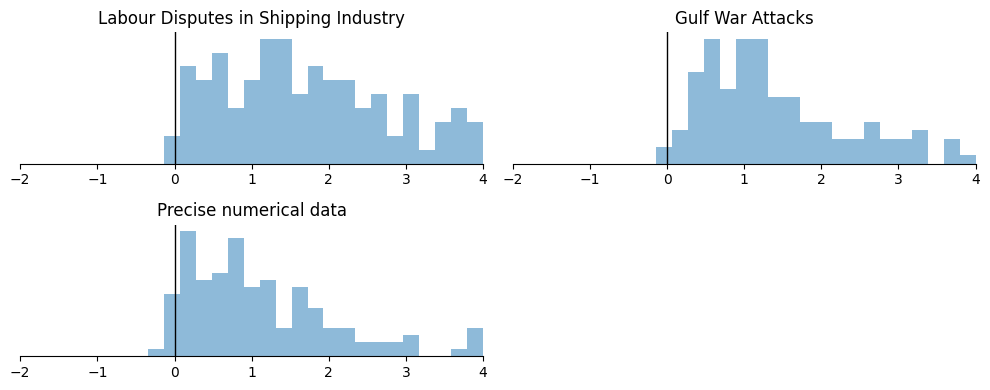

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,4))

bins = np.linspace(-2,4,30)
for ax, s, title in itertools.zip_longest(axs.flat, eta_samples[j,:,idx], df_explain['short_title'], fillvalue=None):
    if s is None:
        ax.axis('off'); continue
    elif ax is None:
        continue;

    ax.hist(s, density=True, alpha=0.5, label=title, bins=bins)

    ax.set_title(title); ax.set_xlim(-2,4); ax.axvline(x=0.0, color='black', linewidth=1); ax.set_yticks([]);

sns.despine(fig, left=True); fig.tight_layout();

# 9. ARBITRARY inspection

We just saw how you can peer into a supervised Sturdy Stats model to see what it learned from the data and why it makes the predictions it does.

However, similar functionality is availble, even for models which aren't trained!
You can provide any two sets of documents, defined by SQL queries, and see which topics differentiate those sets of documents.
This requires the index to be trained, but it does not require a supervised training for the distinction you are making.
Indeed, the AI model can be entirely unsupervised for this analysis!

Here, we'll provide two queries: `pred_crude>0.5` and `pred_crude<0.5`; i.e., we will look at the differences between documents predicted to be related to "crude" and documents predicted not to be.
This should be similar to what we saw from the supervised model.

Note that, without a supervised model, we can only look at *correlations* in this type of analysis.
While we attempt to separate the signal from the noise, without supervised training we are unable to separate correlation from causation.

In [0]:
info = get(f'/{index_id}/topic/diff', dict(q1=f"pred_{label}>0.5", q2=f"pred_{label}<0.5"))
check_status(info)
results = info.json()

pd.DataFrame.from_records(results['topics'])

,confidence,executive_paragraph_summary,one_sentence_summary,prevalence,prevalence_ratio,short_title,topic_group_id,topic_group_short_title,topic_id
0,100,The examples provided showcase a series of mil...,"The theme revolves around various attacks, ret...",0.055791,9.960087,Gulf War Attacks,0,Business and Government Policies,11
1,100,This theme showcases a series of events relate...,A collection of news stories detailing various...,0.103130,8.302635,Labour Disputes in Shipping Industry,0,Business and Government Policies,25
2,100,This theme delves into the agricultural export...,The theme focuses on agricultural export enhan...,0.045533,5.460525,Agricultural Export Credits,0,Business and Government Policies,27
3,100,The European grain trade theme focuses on the ...,The theme revolves around the European Communi...,0.060795,3.232642,European Grain Trade,0,Business and Government Policies,28
4,100,The theme of agricultural legislation and poli...,"This theme covers various legislative actions,...",0.035546,2.802875,Agricultural Legislation and Policies,0,Business and Government Policies,13
5,100,The theme of precise numerical data showcases ...,The theme revolves around detailed numerical d...,0.122827,2.070913,Precise numerical data,1,Financial Market Analysis,6


# Appendix A1: Comparison to scikit-learn classifiers

For comparison, we'll train a scikit-learn classifier on the same data and compare results.
This isn't a particularly meaningful comparison, but is included for completeness.
We'll try the *Multilayer Perceptron* classifier (a feedforward neural network) and the *Multinomial Naive Bayes* (a simple statistical model); both of these are straigtforward to apply to multi-label text classification.

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier


# convert the training data to a format sklearn can read:
#
df_train_dense = df_train['tags'].apply(lambda x: ','.join(x)).str.get_dummies(sep=',')
df_train_dense['doc_id'] = df_train['doc_id']

X = df_train['doc']
y = df_train_dense[df_prediction.columns.drop('doc_id')]


# construct and train an sklearn model
#
try:
    # disable mlflow if on databricks
    import mlflow
    mlflow.autolog(disable=True)
except:
    pass

sk_clf = Pipeline((('vec', CountVectorizer()),
                   ('clf', MLPClassifier())))

sk_clf.fit(X, y)


# run predictions and convert back to our format
#
sk_pred = sk_clf.predict_proba(df_test['doc'])

df_skpred = pd.DataFrame(sk_pred)
df_skpred.columns = df_prediction.columns.drop('doc_id')
df_skpred['doc_id'] = df_test['doc_id'].values
df_skpred = df_skpred[df_prediction.columns]

df_skpred.head()

,doc_id,acq,corn,crude,earn,gold,grain,interest,money-fx,ship,trade,wheat
0,0c63275952f38426566f61a081d5d9eb,0.000730,4.952372e-07,0.000012,1.551964e-10,1.447300e-08,2.027919e-06,4.981363e-07,0.000003,2.886726e-07,0.000108,8.383128e-08
1,0c6e9d89636a933953d9975dadfb53e7,0.000001,9.576685e-07,0.000003,3.653961e-04,4.860202e-06,1.971839e-06,2.175343e-04,0.000070,1.971918e-06,0.000030,1.624913e-06
2,0c80c00a7bd3d987a43ba8d49814f8df,0.000033,2.401030e-05,0.000013,9.999124e-01,5.972036e-06,2.972790e-05,1.398992e-05,0.000037,1.813093e-05,0.000007,1.949908e-05
3,0c8e4f9fbac26ed04a8cdab0df80e578,0.449594,1.024204e-04,0.000159,1.420598e-03,8.084743e-05,7.765807e-05,1.200370e-04,0.001803,1.418747e-04,0.000118,4.007914e-05
4,0ca077c8a8f5025f2f856ecb4fd59b3a,0.004147,3.004551e-07,0.000001,1.918001e-08,4.873139e-09,3.204638e-07,7.186410e-07,0.000313,2.001611e-07,0.000075,3.225276e-08


In [0]:
records = []
for tag in df_prediction.columns.drop('doc_id'):
    p, r, f, _ = precision_recall_fscore_support(df_test_dense[tag].values, df_skpred[tag].values>0.5, 
                                                 average='macro', zero_division=0.0)
    a = roc_auc_score(df_test_dense[tag].values, df_skpred[tag].values, average='macro')
    records.append({'label': tag, 'precision': p, 'recall': r, 'f1': f, 'AUC': a})

df_sk_metrics = pd.DataFrame.from_records(records)

df_sk_metrics

,label,precision,recall,f1,AUC
0,acq,0.953416,0.889034,0.916241,0.970160
1,corn,0.903399,0.582199,0.632611,0.719580
2,crude,0.969829,0.605450,0.662718,0.742625
3,earn,0.961889,0.935212,0.946261,0.961493
4,gold,0.995396,0.540000,0.571762,0.769131
5,grain,0.945338,0.667867,0.737934,0.831000
6,interest,0.876891,0.688294,0.748192,0.861176
7,money-fx,0.925749,0.757766,0.818381,0.891192
8,ship,0.772996,0.514959,0.522395,0.691511
9,trade,0.961469,0.557499,0.592990,0.747885


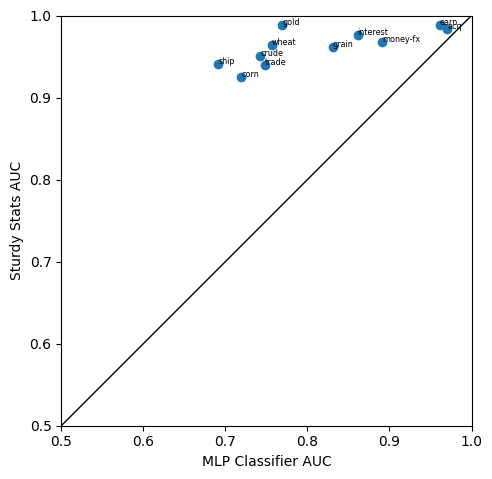

In [0]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(df_sk_metrics['AUC'], df_metrics['AUC'])
for xx, yy, ss in zip(df_sk_metrics['AUC'], df_metrics['AUC'], df_metrics['label']):
    ax.text(xx, yy, ss, fontsize='xx-small')
ax.plot([0,1], [0,1], color='black', linewidth=1)
ax.set_xlim([0.5, 1]); ax.set_ylim([0.5, 1]); ax.set_aspect(1.0)
ax.set_xlabel('MLP Classifier AUC'); ax.set_ylabel('Sturdy Stats AUC');

fig.tight_layout()

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB


# convert the training data to a format sklearn can read:
#
df_train_dense = df_train['tags'].apply(lambda x: ','.join(x)).str.get_dummies(sep=',')
df_train_dense['doc_id'] = df_train['doc_id']

X = df_train['doc']
y = df_train_dense[df_prediction.columns.drop('doc_id')]


# construct and train an sklearn model
#
try:
    # disable mlflow if on databricks
    import mlflow
    mlflow.autolog(disable=True)
except:
    pass

sk_clf = Pipeline((('vec', CountVectorizer()),
                   ('clf', OneVsRestClassifier(MultinomialNB()))))

sk_clf.fit(X, y)


# run predictions and convert back to our format
#
sk_pred = sk_clf.predict_proba(df_test['doc'])

df_skpred = pd.DataFrame(sk_pred)
df_skpred.columns = df_prediction.columns.drop('doc_id')
df_skpred['doc_id'] = df_test['doc_id'].values
df_skpred = df_skpred[df_prediction.columns]

df_skpred.head()

,doc_id,acq,corn,crude,earn,gold,grain,interest,money-fx,ship,trade,wheat
0,0c63275952f38426566f61a081d5d9eb,2.340450e-27,2.615912e-64,1.629835e-25,1.055060e-82,7.542532e-63,8.295734e-38,1.618994e-53,1.290659e-19,3.589083e-75,6.508249e-13,3.725141e-68
1,0c6e9d89636a933953d9975dadfb53e7,2.545431e-47,1.976159e-59,1.299536e-38,4.986704e-24,4.991726e-40,1.025111e-41,1.657700e-30,2.216039e-18,3.099619e-64,1.581442e-42,2.083040e-52
2,0c80c00a7bd3d987a43ba8d49814f8df,4.707482e-40,4.612955e-42,8.480157e-39,1.000000e+00,2.172357e-40,3.427586e-41,2.277408e-49,1.922566e-51,2.330195e-45,1.205872e-54,7.004075e-41
3,0c8e4f9fbac26ed04a8cdab0df80e578,1.426491e-01,1.424604e-32,2.364225e-17,1.235339e-10,1.311035e-27,8.813887e-26,9.083388e-27,5.468257e-16,1.366091e-35,2.686686e-26,4.590406e-35
4,0ca077c8a8f5025f2f856ecb4fd59b3a,5.566214e-23,1.204266e-66,1.476195e-35,1.244013e-67,1.372256e-61,1.778465e-46,7.254024e-46,4.926553e-12,5.514692e-74,9.981640e-01,5.144332e-82


In [0]:
records = []
for tag in df_prediction.columns.drop('doc_id'):
    p, r, f, _ = precision_recall_fscore_support(df_test_dense[tag].values, df_skpred[tag].values>0.5, 
                                                 average='macro', zero_division=0.0)
    a = roc_auc_score(df_test_dense[tag].values, df_skpred[tag].values, average='macro')
    records.append({'label': tag, 'precision': p, 'recall': r, 'f1': f, 'AUC': a})

df_sk_metrics = pd.DataFrame.from_records(records)

df_sk_metrics

,label,precision,recall,f1,AUC
0,acq,0.954598,0.930435,0.941807,0.977619
1,corn,0.937531,0.573708,0.621798,0.675237
2,crude,0.918872,0.698309,0.764847,0.854255
3,earn,0.952883,0.939692,0.945651,0.963594
4,gold,0.995495,0.550000,0.588647,0.746186
5,grain,0.909113,0.705361,0.769806,0.850023
6,interest,0.793960,0.622133,0.668806,0.835816
7,money-fx,0.863758,0.912092,0.886147,0.975373
8,ship,0.844525,0.518879,0.529742,0.679911
9,trade,0.860170,0.688317,0.744674,0.811298


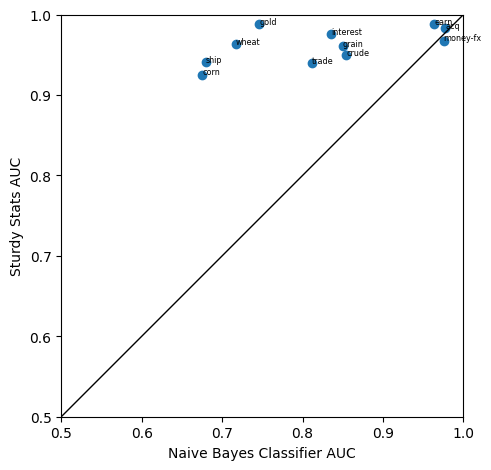

In [0]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(df_sk_metrics['AUC'], df_metrics['AUC'])
for xx, yy, ss in zip(df_sk_metrics['AUC'], df_metrics['AUC'], df_metrics['label']):
    ax.text(xx, yy, ss, fontsize='xx-small')
ax.plot([0,1], [0,1], color='black', linewidth=1)
ax.set_xlim([0.5, 1]); ax.set_ylim([0.5, 1]); ax.set_aspect(1.0)
ax.set_xlabel('Naive Bayes Classifier AUC'); ax.set_ylabel('Sturdy Stats AUC');

fig.tight_layout()